In [58]:
require(ggplot2)
require(stringr)
require(tidyr)
require(dplyr)
require(gplots)
require(viridis)

Loading required package: viridis


# Process transcripts

In [13]:

# read the table from a file
transcripts <- read.table('transcript_100', sep='\t', header=T)
names(transcripts)[1] <- 'Cf_12h_1.'

# add the gene names as an explicit column instead of just an index
transcripts$gene <- rownames(transcripts)

# convert to "long" instead of "wide" data format
long_transcripts <- gather(transcripts, key='condition', value='cpm', -gene)

# parse condition strings 
t_condition_strings <- str_split_fixed(long_transcripts$condition, '_', 3)
long_transcripts$timepoint <- t_condition_strings[, 2]
long_transcripts$pathogen <- t_condition_strings[, 1]
long_transcripts$replicate <- str_replace_all(t_condition_strings[, 3], '[.]', '')

# drop old conditions column, keeping only parsed columns
long_transcripts <- long_transcripts[, c('gene', 'cpm', 'timepoint', 'pathogen', 'replicate')]

# Process metabolites

In [14]:
# read data from file
metabolites <- read.table('metabolite_100', sep='\t', header=T)

# discard extra conditions for which no transcriptomic data was available
is_third_rep <- str_detect(names(metabolites), '_3_')
is_not_third_rep <- ! is_third_rep

extra_conditions <- str_detect(names(metabolites), '[34]dpi')
not_extra_conditions <- ! extra_conditions
filtered_metabolites <- metabolites[ , is_not_third_rep & not_extra_conditions]

# convert to long rather than "wide" format
long_mets <- gather(filtered_metabolites, key='condition', value='peak_area', -me)

# parse condition strings
condition_strings <- str_split_fixed(long_mets$condition, '_', 5)
long_mets$timepoint <- condition_strings[, 2]
long_mets$pathogen <- condition_strings[, 3]
long_mets$replicate <- condition_strings[, 4]

# handle "mock" separately since there should be two mocks, 'Mk' and "Mk2"
dates <- as.factor(condition_strings[, 5])
long_mets[long_mets$pathogen == 'Mock' & dates == '150306', 'pathogen'] <- 'Mk'
long_mets[long_mets$pathogen == 'Mock' & dates == '150424', 'pathogen'] <- 'Mk2'

# drop old conditions column, keeping only parsed columns
long_mets <- long_mets[, c('me', 'peak_area', 'timepoint', 'pathogen', 'replicate')]

In [20]:
# harmonize factor levels for time points, pathogens, and replicate num
## convert "char" columns to "factor" columns
long_mets <- as.data.frame(unclass(long_mets))
long_transcripts <- as.data.frame(unclass(long_transcripts))

## list factor levels
levels(long_transcripts$timepoint)
levels(long_mets$timepoint) 

### force levels to be the same
levels(long_mets$timepoint) <- levels(long_transcripts$timepoint)
levels(long_mets$pathogen) <- levels(long_transcripts$pathogen)

[1] "12h" "24h" "48h"

[1] "12h" "24h" "48h"

In [21]:
head(long_mets)
head(long_transcripts)

me peak_area timepoint pathogen replicate
1  M721T670 39630.721       12h       Cf         1
2 M812T1705 10918.015       12h       Cf         1
3  M479T603 40074.867       12h       Cf         1
4 M811T1704 12310.114       12h       Cf         1
5 M442T1447 11795.600       12h       Cf         1
6 M236T1705  1563.484       12h       Cf         1

gene cpm timepoint pathogen replicate
1 Solyc07g007240.2   1       12h       Cf         1
2 Solyc01g008050.2  NA       12h       Cf         1
3 Solyc05g052280.2 234       12h       Cf         1
4 Solyc02g084790.2   0       12h       Cf         1
5 Solyc07g017980.1   0       12h       Cf         1
6 Solyc01g103060.2   4       12h       Cf         1

# A few quality-control graphs

In [22]:
levels(long_mets$pathogen)

[1] "Cf"  "Ct"  "Fg"  "Mk"  "Mk2" "Mz"  "Pb"  "Sc"  "Xe"

Warning message:
: Removed 307 rows containing non-finite values (stat_bin).

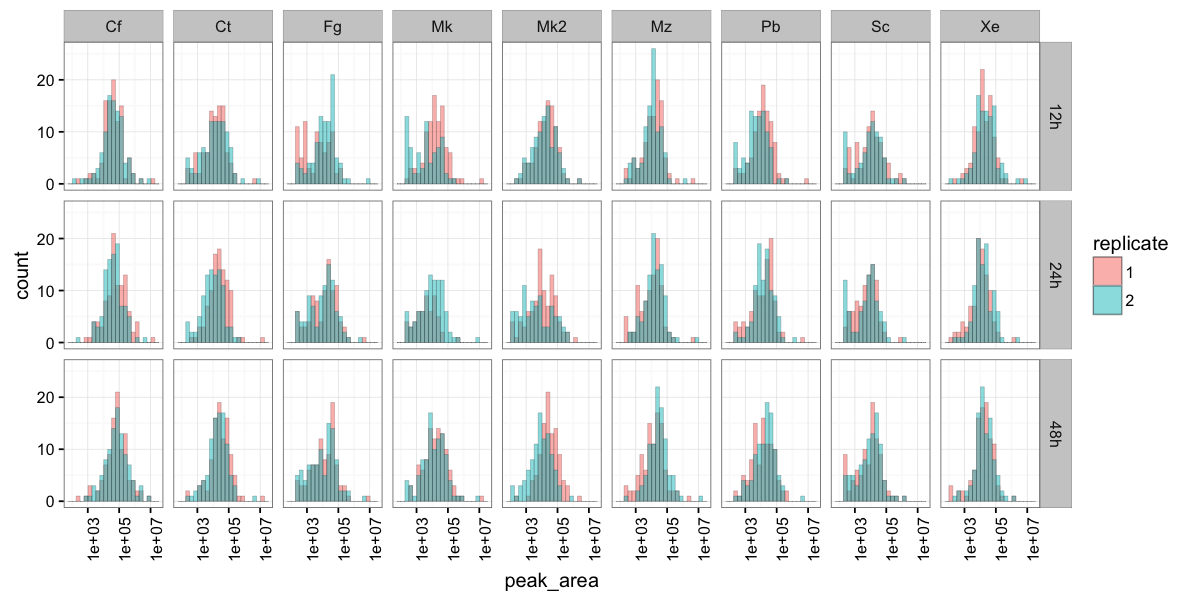

In [23]:
options(repr.plot.width=10, repr.plot.height=5)

ggplot(data=long_mets, aes(x=peak_area, fill=replicate)) + 
    geom_histogram(bins=20, position='identity', alpha=0.5, color='black', size=0.1) + 
    scale_x_log10() + 
    theme_bw() +
    facet_grid(timepoint~pathogen) + 
    theme(axis.text.x = element_text(angle = 90))

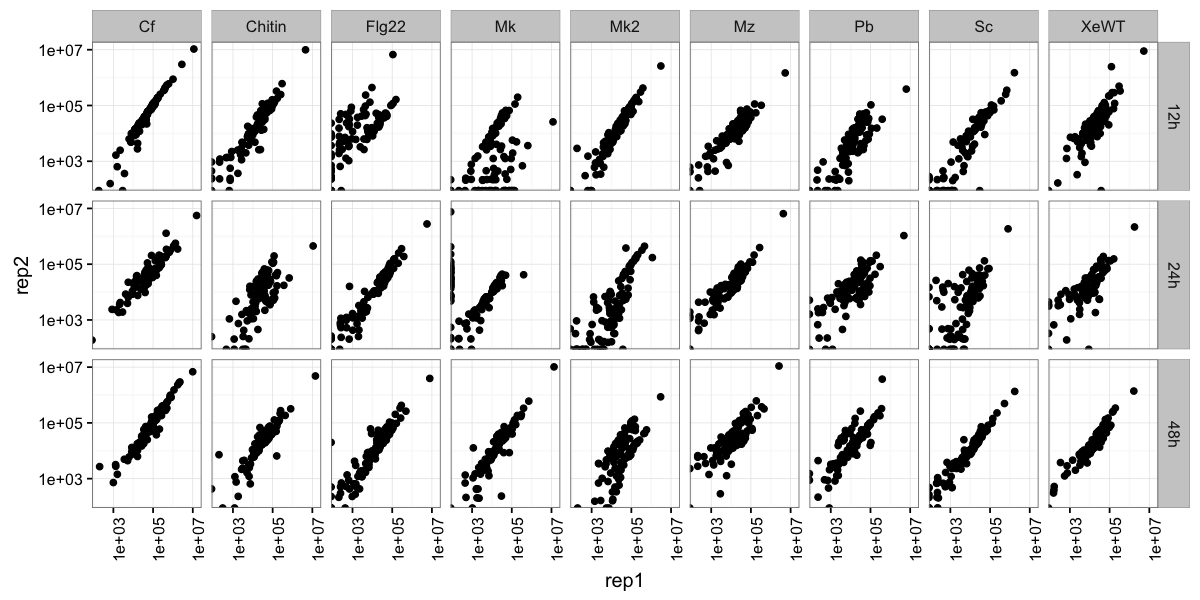

In [7]:
# check reproducibility between replicates for metabolites

met_reps <- long_mets %>% 
            group_by(me, timepoint, pathogen) %>%
            summarize(mean=mean(peak_area), sd = sd(peak_area), rep1=peak_area[1], rep2=peak_area[2])

ggplot(data=met_reps, aes(x=rep1, y=rep2)) + 
    geom_point() + 
    scale_x_log10() + 
    scale_y_log10() +
    theme_bw() +
    facet_grid(timepoint~pathogen) + 
    theme(axis.text.x = element_text(angle = 90)) 

Warning message:
: Removed 1 rows containing missing values (geom_point).

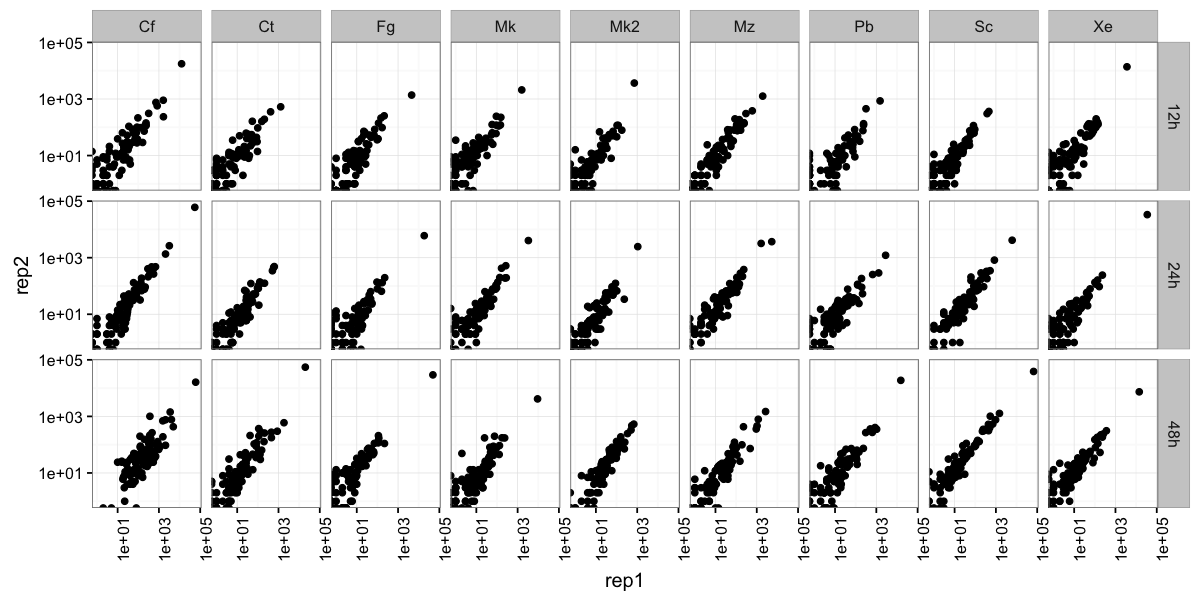

In [8]:
# check reproducibility between replicates for transcripts
trans_reps <- long_transcripts %>% 
            group_by(gene, timepoint, pathogen) %>%
            summarize(mean=mean(cpm), sd = sd(cpm), rep1=cpm[1], rep2=cpm[2])

ggplot(data=trans_reps, aes(x=rep1, y=rep2)) + 
    geom_point() + 
    scale_x_log10() + 
    scale_y_log10() +
    theme_bw() +
    facet_grid(timepoint~pathogen) + 
    theme(axis.text.x = element_text(angle = 90))

In [52]:
# make group transcripts and metabolites
## make each table "long" again

wide_mets <- long_mets %>% 
             unite(condition, pathogen, timepoint, replicate) %>%
             spread(condition, peak_area)

wide_trans <- long_transcripts %>%
              unite(condition, pathogen, timepoint, replicate) %>%
              spread(condition, cpm)

wide_trans[is.na(wide_trans)] <- 0

## make z-scores instead of raw values
mets_zscores <- as.data.frame(apply(wide_mets[, -1], 2, scale))
trans_zscores <- as.data.frame(apply(wide_trans[, -1], 2, scale))

mets_zscores$identifier <- wide_mets$me
mets_zscores$type <- 'metabolite'

trans_zscores$identifier <- wide_trans$gene
trans_zscores$type <- 'transcript'

# combine!
all_data <- rbind(trans_zscores, mets_zscores)

dim(all_data)

[1] 200  56

In [54]:
# do clustering!

## isolate matrix of z-scores
all_matrix <- as.matrix(all_data[, 1:54])

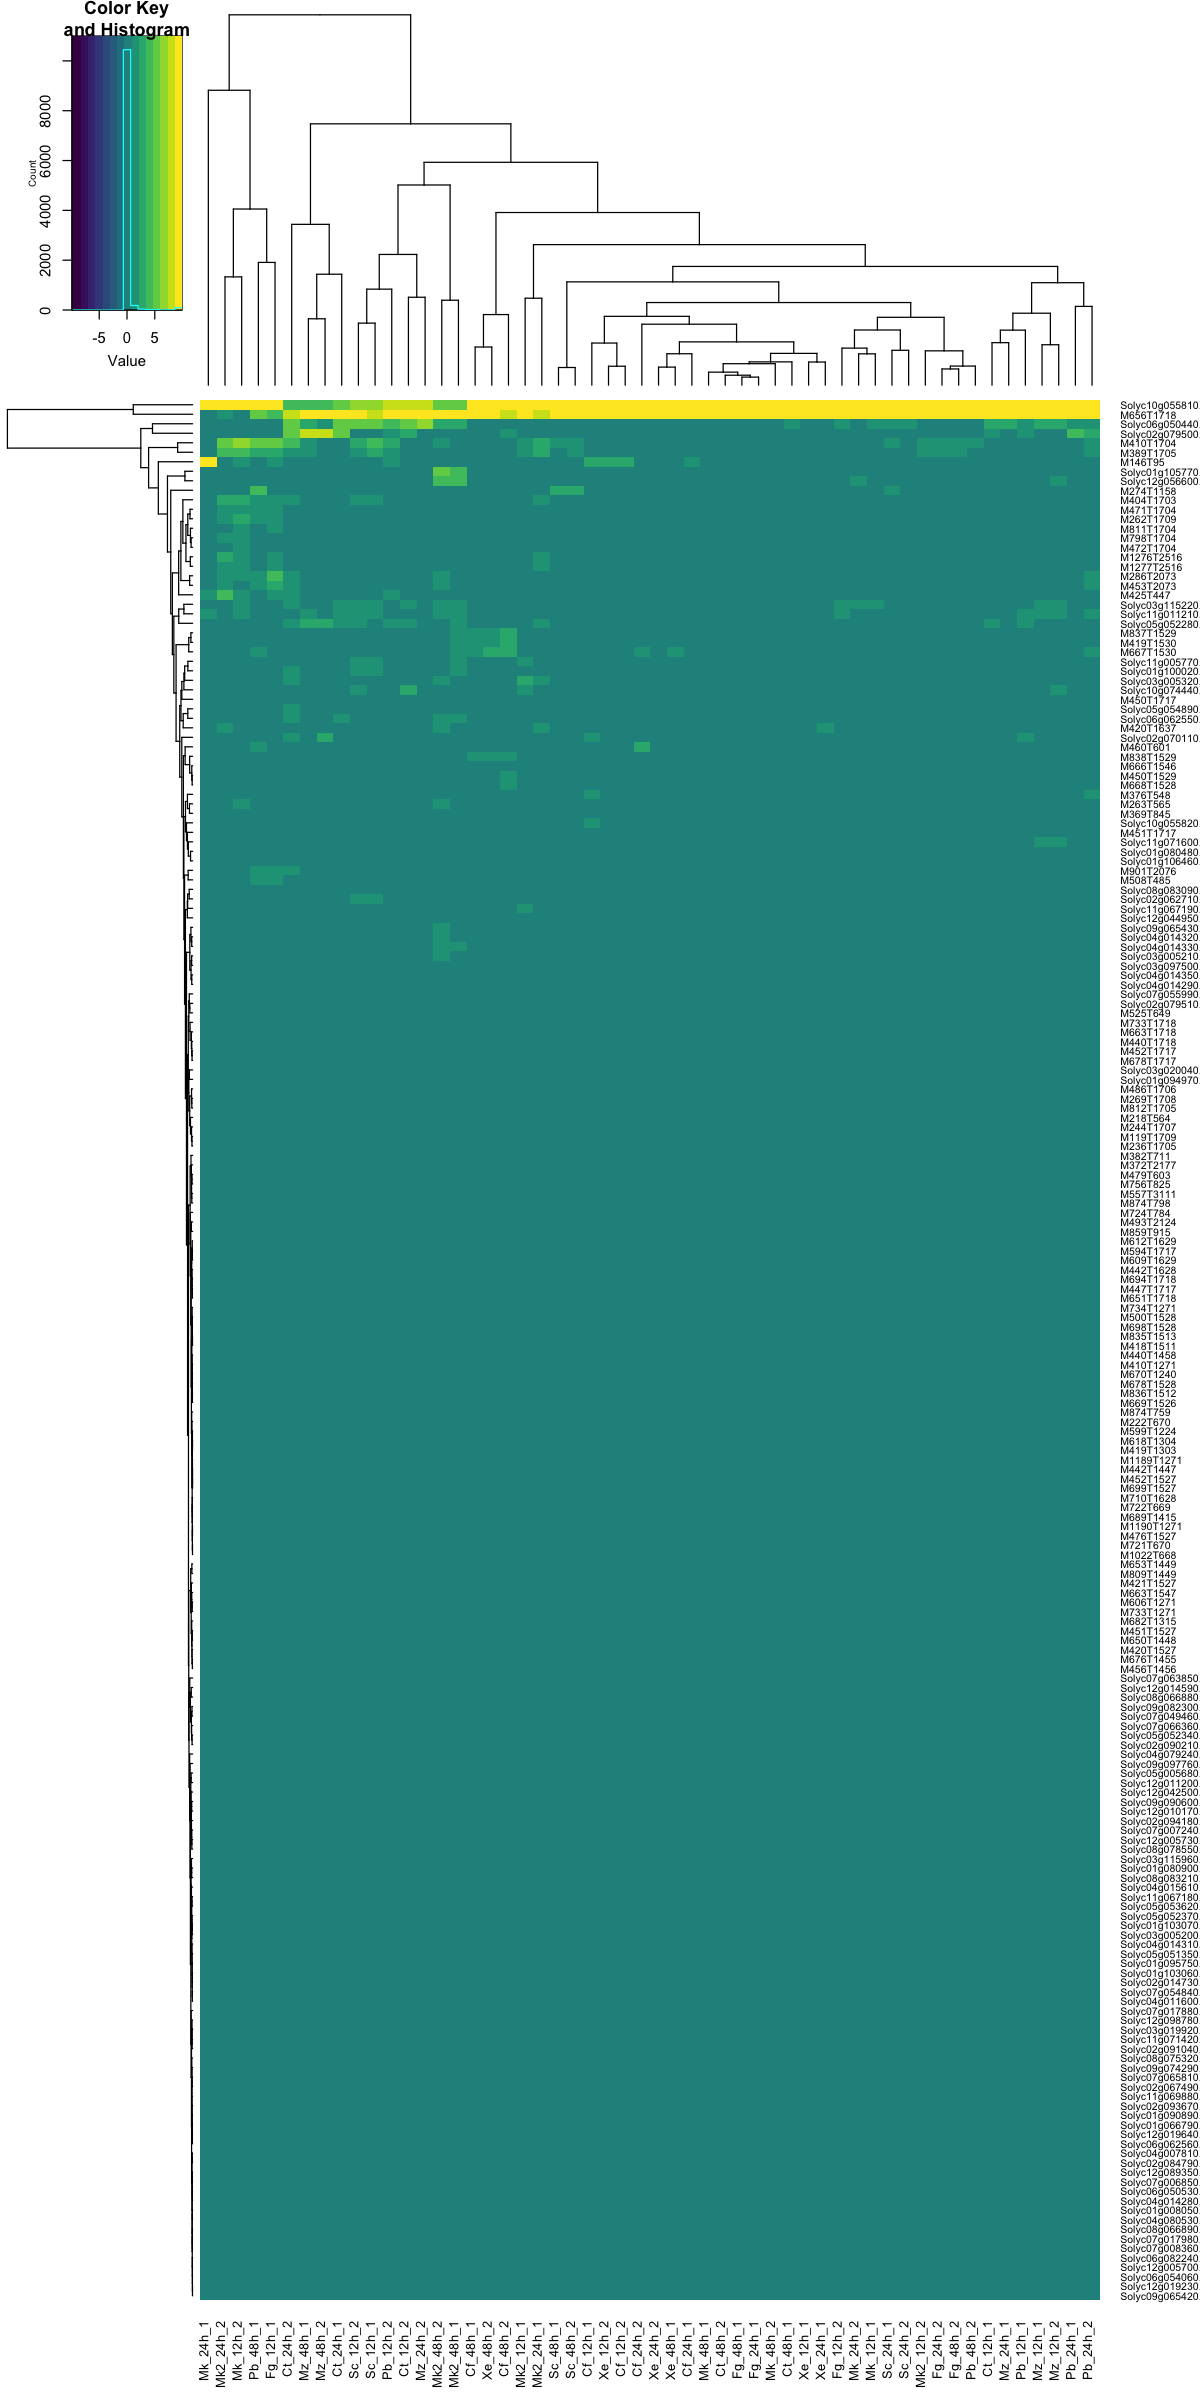

In [65]:
options(repr.plot.width=10, repr.plot.height=20)
heatmap.2(all_matrix, scale = 'none', trace='none', col='viridis', keysize=0.8, labRow = all_data$identifier)